In [17]:
import numpy as np
import torch
print(torch.__version__)

1.8.0a0+ea2a568


In [21]:
from notmnist import load_notmnist

letters = 'ABCDEFGHIJ'
X_train, y_train, X_test, y_test = load_notmnist(letters=letters)
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

print("Train size = %i, test_size = %i" % (len(X_train), len(X_test)))

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done
Train size = 14043, test_size = 4681


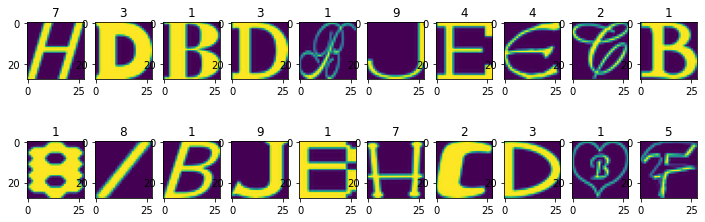

In [11]:
%matplotlib inline
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

Let's start with layers. The main abstraction here is __`torch.nn.Module`__:

In [13]:
from torch import nn
import torch.nn.functional as F

 __Softmax__.
$$ \text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}} $$


In [24]:
print(X_train.shape)

input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = len(letters)

model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim, output_dim),
    nn.Softmax()
)

(14043, 784)


In [25]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([64, 784]), torch.Size([64]), torch.Size([10, 64]), torch.Size([10])]


In [26]:
# create dummy data with 3 samples and 784 features
x = torch.tensor(X_train[:3], dtype=torch.float32)
y = torch.tensor(y_train[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = model(x)[:, 0]

y_predicted  # display what we've got

/home/student/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0.1282, 0.0878, 0.0952], grad_fn=<SelectBackward>)

Let's now define a loss function for our model.

The natural choice is to use binary crossentropy (aka logloss, negative llh):
$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot log P(y_i=1 | X_i) + (1-y_i) \cdot log (1-P(y_i=1 | X_i)) ]$$



In [ ]:
crossentropy = <YOUR CODE>

loss = <YOUR CODE>

assert tuple(crossentropy.size()) == (
    3,), "Crossentropy must be a vector with element per sample"
assert tuple(loss.size()) == tuple(
), "Loss must be scalar. Did you forget the mean/sum?"
assert loss.data.numpy() > 0, "Crossentropy must non-negative, zero only for perfect prediction"
assert loss.data.numpy() <= np.log(
    3), "Loss is too large even for untrained model. Please double-check it."

__Note:__ you can also find many such functions in `torch.nn.functional`, just type __`F.<tab>`__.

__Torch optimizers__

When we trained Linear Regression above, we had to manually `.zero_()` gradients on both our variables. Imagine that code for a 50-layer network.

Again, to keep it from getting dirty, there's `torch.optim` module with pre-implemented algorithms:

In [ ]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.01)

# here's how it's used:
opt.zero_grad()      # clear gradients
loss.backward()      # add new gradients
opt.step()           # change weights

In [ ]:
# dispose of old variables to avoid bugs later
del x, y, y_predicted, loss, y_pred

### Putting it all together

In [ ]:
# create network again just in case
model = nn.Sequential()
model.add_module('first', nn.Linear(784, 1))
model.add_module('second', nn.Sigmoid())

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
history = []

for i in range(100):

    # sample 256 random images
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)

    # predict probabilities
    y_predicted = <YOUR CODE>

    assert y_predicted.dim(
    ) == 1, "did you forget to select first column with [:, 0]"

    # compute loss, just like before
    loss = <YOUR CODE>

    # compute gradients
    <YOUR CODE>

    # Adam step
    <YOUR CODE>

    # clear gradients
    <YOUR CODE>

    history.append(loss.data.numpy())

    if i % 10 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 0.573
step #10 | mean loss = 0.371
step #20 | mean loss = 0.218
step #30 | mean loss = 0.159
step #40 | mean loss = 0.141
step #50 | mean loss = 0.127
step #60 | mean loss = 0.131
step #70 | mean loss = 0.107
step #80 | mean loss = 0.116
step #90 | mean loss = 0.101


__Debugging tips:__
* Make sure your model predicts probabilities correctly. Just print them and see what's inside.
* Don't forget the _minus_ sign in the loss function! It's a mistake 99% people do at some point.
* Make sure you zero-out gradients after each step. Seriously:)
* In general, PyTorch's error messages are quite helpful, read 'em before you google 'em.
* if you see nan/inf, print what happens at each iteration to find our where exactly it occurs.
  * If loss goes down and then turns nan midway through, try smaller learning rate. (Our current loss formula is unstable).

### Evaluation

Let's see how our model performs on test data

In [ ]:
# use your model to predict classes (0 or 1) for all test samples
predicted_y_test = <YOUR CODE>

assert isinstance(predicted_y_test, np.ndarray), "please return np array, not %s" % type(
    predicted_y_test)
assert predicted_y_test.shape == y_test.shape, "please predict one class for each test sample"
assert np.in1d(predicted_y_test, y_test).all(), "please predict class indexes"

accuracy = np.mean(predicted_y_test == y_test)

print("Test accuracy: %.5f" % accuracy)
assert accuracy > 0.95, "try training longer"

Test accuracy: 0.96585


## More about PyTorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on PyTorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* PyTorch examples - a repo that implements many cool DL models in PyTorch - [link](https://github.com/pytorch/examples)
* Practical PyTorch - a repo that implements some... other cool DL models... yes, in PyTorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)

---

# Homework tasks

There will be three tasks worth 2, 3 and 5 points respectively.
If you get stuck with no progress, try switching to the next task and returning later.

### Task I (2 points) - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword.


__1.1 The Cannabola__
[(_disclaimer_)](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

In [ ]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = <YOUR CODE>

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = <YOUR CODE>
y = <YOUR CODE>


plt.figure(figsize=[6, 6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: The Game of Life (3 points)

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure PyTorch_.

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU!__ Indeed, what could be a better use of your GPU than simulating Game of Life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the URL above out of sloth, here's the Game of Life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference NumPy implementation that you must convert to PyTorch.
_[NumPy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format.

__Note 2:__ From the mathematical standpoint, PyTorch convolution is actually cross-correlation. Those two are very similar operations. More info: [video tutorial](https://www.youtube.com/watch?v=C3EEy8adxvc), [scipy functions review](http://programmerz.ru/questions/26903/2d-convolution-in-python-similar-to-matlabs-conv2-question), [stack overflow source](https://stackoverflow.com/questions/31139977/comparing-matlabs-conv2-with-scipys-convolve2d).

In [ ]:
from scipy.signal import correlate2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]])

    N = correlate2d(Z, filters, mode='same')

    # Apply rules
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive
    return Z

In [ ]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.

    You can opt to create a new tensor or change Z inplace.
    """

    <YOUR CODE>

    return Z

In [ ]:
# initial frame
Z_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

# your debug polygon :)
Z_new = torch_update(Z.clone())

# tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), \
    "your PyTorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

In [ ]:
%matplotlib notebook
plt.ion()

# initialize game field
Z = np.random.choice([0, 1], size=(100, 100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    # update
    Z = torch_update(Z)

    # re-draw image
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

In [ ]:
# Some fun setups for your amusement

# parallel stripes
Z = np.arange(100) % 2 + np.zeros([100, 100])
# with a small imperfection
Z[48:52, 50] = 1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

### Task III: Going deeper (5 points)
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>
Your ultimate task for this week is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve the same digit recognition problem, but at a larger scale

* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression.

With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train using __categorical crossentropy__  (see [here](http://wiki.fast.ai/index.php/Log_Loss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors.
If you feel confident enough, just start coding right away and get there ~~if~~ once you need to untangle yourself.

In [ ]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

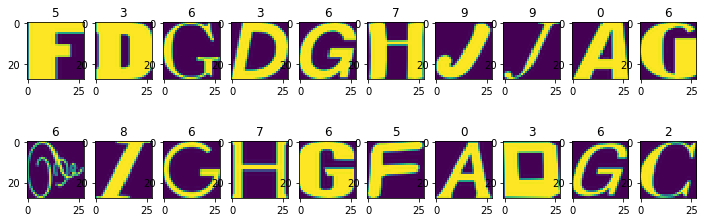

In [ ]:
%matplotlib inline
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

In [ ]:
<YOUR CODE: a whole lot of it>

<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>

# SPOILERS!

Recommended pipeline:

* Adapt logistic regression from previous assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - Softmax (exp over sum of exps) can be implemented manually or as `nn.Softmax` (layer) or `F.softmax` (function)
  - Probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - You can also try momentum/rmsprop/adawhatever
    - in which case the dataset should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just the output layer :)
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
  - In ideal case this totals to 2 `torch.matmul`'s, 1 softmax and 1 ReLU/sigmoid
  - __Make sure this neural network works better than logistic regression!__

* Now's the time to try improving the network. Consider layers (size, neuron count), nonlinearities, optimization methods, initialization — whatever you want, but please avoid convolutions for now.

* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate $\log P(y \mid x)$ as `F.log_softmax(layer_before_softmax)`.